## Video Game Sales Prediction Weekend Hackathon 10

- The gaming industry is certainly one of the thriving industries of the modern age and one of those that are most influenced by the advancement in technology. 
- With the availability of technologies like AR/VR in consumer products like gaming consoles and even smartphones, the gaming sector shows great potential. 
- In this hackathon, you as a data scientist must use your analytical skills to predict the sales of video games depending on given factors. 
- Given are 8 distinguishing factors that can influence the sales of a video game. 
- Your objective as a data scientist is to build a machine learning model that can accurately predict the sales in millions of units for a given game.

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings(action='ignore')

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

from sklearn.tree import DecisionTreeRegressor,ExtraTreeRegressor
from sklearn.ensemble import RandomForestRegressor,ExtraTreesRegressor,\
                    GradientBoostingRegressor,BaggingRegressor,AdaBoostRegressor
    
import xgboost as xgb
import lightgbm as lgb
import catboost as cat

from sklearn.model_selection import StratifiedKFold

In [2]:
def metric(y_test, y_pred):
    rmse = mean_squared_error(y_test, y_pred , squared=False)
    return rmse

In [3]:
train = pd.read_csv("data/Train.csv")
test = pd.read_csv("data/Test.csv")
sample = pd.read_csv("data/Sample_Submission.csv")

In [4]:
dtrain = train.copy()
dtest = test.copy()

In [5]:
train.shape, test.shape

((3506, 9), (1503, 8))

In [6]:
train.head()

,ID,CONSOLE,YEAR,CATEGORY,PUBLISHER,RATING,CRITICS_POINTS,USER_POINTS,SalesInMillions
0,2860,ds,2008,role-playing,Nintendo,E,2.833333,0.303704,1.779257
1,731,wii,2012,simulation,Konami Digital Entertainment,E10+,13.200000,1.640000,0.215050
2,495,pc,2019,shooter,Activision,M,4.562500,0.006410,0.534402
3,2641,ps2,2002,sports,Electronic Arts,E,4.181818,0.326923,1.383964
4,811,ps3,2013,action,Activision,M,2.259259,0.032579,0.082671


In [7]:
train.nunique()

ID                 2654
CONSOLE              17
YEAR                 23
CATEGORY             12
PUBLISHER           204
RATING                6
CRITICS_POINTS     1683
USER_POINTS        2187
SalesInMillions    3506
dtype: int64

In [8]:
train.describe()

,ID,YEAR,CRITICS_POINTS,USER_POINTS,SalesInMillions
count,3506.000000,3506.000000,3506.000000,3506.000000,3506.000000
mean,2282.233600,2008.990302,3.790831,0.405824,2.171021
std,1287.273422,4.304252,3.141781,0.455541,2.495396
min,1.000000,1997.000000,0.568966,0.000341,0.001524
25%,1220.250000,2006.000000,1.738095,0.065966,0.965679
50%,2262.500000,2009.000000,2.766667,0.233333,1.866140
75%,3404.750000,2012.000000,4.621528,0.598333,2.792029
max,4523.000000,2019.000000,23.250000,2.325000,84.226041


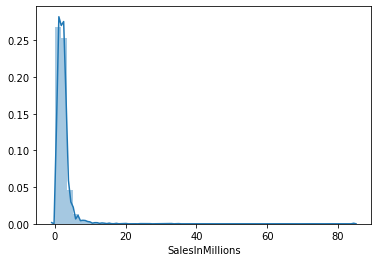

In [9]:
sns.distplot(train['SalesInMillions'])

In [10]:
def k_fold_cross_valid(model,x_train,y_train,n_splits=5):
    
    X = x_train.copy()
    y = y_train.copy()

    from sklearn.model_selection import KFold
    kf = KFold(n_splits=5)
    kf.get_n_splits(X)
    res = []

    for train_index, test_index in kf.split(X):
        
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model.fit(X_train,y_train)
        y_pred = model.predict(X_test)
    
        res.append(metric(y_test,y_pred))
        
    print("RMSE:",np.array(res).mean())

In [11]:
def plot_importance(model,features):
   
    model.fit(train[features],train[target])
    importances = model.feature_importances_
    indices = np.argsort(importances)

    plt.title('Feature Importances')
    plt.barh(range(len(indices)), importances[indices], color='g', align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()

In [12]:
cat_feat = ['CONSOLE','CATEGORY', 'PUBLISHER', 'RATING']
features = list(set(train.columns)-set(['SalesInMillions']))
target = 'SalesInMillions'
features

['ID',
 'CRITICS_POINTS',
 'YEAR',
 'USER_POINTS',
 'CONSOLE',
 'RATING',
 'CATEGORY',
 'PUBLISHER']

In [13]:
model = cat.CatBoostRegressor(random_state=100,cat_features=cat_feat,verbose=0)
k_fold_cross_valid(model,train[features],train[target],n_splits=5)
model.fit(train[features],train[target])
y_pred = model.predict(test[features])
sub = pd.DataFrame(y_pred,columns=[target])

RMSE: 1.9461135494000286


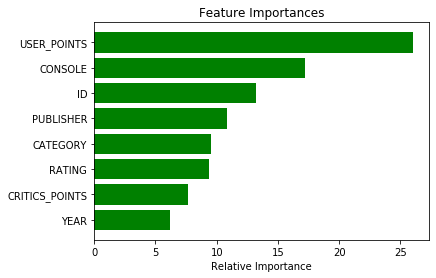

In [14]:
model = cat.CatBoostRegressor(random_state=100,cat_features=cat_feat,verbose=0)
plot_importance(model,features)

In [15]:
m1 = sub['SalesInMillions'].values

## LGB Model

In [16]:
def Stratified_Kfold(model,train,target,test,features,folds):
    max_iter = folds
    folds = StratifiedKFold(n_splits = max_iter)
    oofs = np.zeros(len(train))
    test_preds = np.zeros(len(test))


    for fold_, (trn_idx, val_idx) in enumerate(folds.split(train, pd.qcut(target, 10, labels=False, duplicates='drop'))):

        print(f'\n---- Fold {fold_} -----\n')

        X_trn, y_trn = train.iloc[trn_idx][features], target.iloc[trn_idx]
        X_val, y_val = train.iloc[val_idx][features], target.iloc[val_idx]
        X_test = test[features]
        print(X_trn.shape[1], X_val.shape[1])


        _ = model.fit(X_trn, y_trn, eval_set = [(X_val, y_val)], verbose=100, early_stopping_rounds=200, eval_metric='rmse')

        oofs[val_idx] = model.predict(X_val)
        current_test_pred = model.predict(X_test)
        test_preds += model.predict(X_test)/max_iter

        print(f'\n Fold {metric(y_val, oofs[val_idx])}')


    print(f'\nOOF val score: {metric(target,oofs)}')
    
    return test_preds

In [17]:
train = dtrain.copy()
test = dtest.copy()

In [18]:
cat_feat = ['CONSOLE','YEAR','CATEGORY','PUBLISHER','RATING']

from sklearn.preprocessing import LabelEncoder
label_classes = {}

data = pd.concat([train,test])

for i in cat_feat:
    le = LabelEncoder()
    data[i] = le.fit_transform(data[i])
    label_classes[i] = le
    
train = data[data['SalesInMillions'].notnull()]
test = data[data['SalesInMillions'].isnull()]

In [19]:
features = [c for c in train.columns if c not in ['SalesInMillions']]
target = train['SalesInMillions']
features

['CATEGORY',
 'CONSOLE',
 'CRITICS_POINTS',
 'ID',
 'PUBLISHER',
 'RATING',
 'USER_POINTS',
 'YEAR']

In [20]:
model = lgb.LGBMRegressor(n_estimators=1000,learning_rate=0.02)
m2 = Stratified_Kfold(model,train,target,test,features,10)


---- Fold 0 -----

8 8
Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 1.50219	valid_0's l2: 2.25656
[200]	valid_0's rmse: 1.52578	valid_0's l2: 2.32799
Early stopping, best iteration is:
[63]	valid_0's rmse: 1.48904	valid_0's l2: 2.21724

 Fold 1.4890386263356403

---- Fold 1 -----

8 8
Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 1.75233	valid_0's l2: 3.07065
[200]	valid_0's rmse: 1.71429	valid_0's l2: 2.9388
[300]	valid_0's rmse: 1.71381	valid_0's l2: 2.93716
[400]	valid_0's rmse: 1.71162	valid_0's l2: 2.92964
[500]	valid_0's rmse: 1.72294	valid_0's l2: 2.96853
[600]	valid_0's rmse: 1.72666	valid_0's l2: 2.98136
Early stopping, best iteration is:
[417]	valid_0's rmse: 1.70967	valid_0's l2: 2.92297

 Fold 1.7096706737706058

---- Fold 2 -----

8 8
Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 2.00205	valid_0's l2: 4.00822
[200]	valid_0's rmse: 2.00426	valid_0's l2: 4.0170

## XGB Model

In [21]:
model = xgb.XGBRegressor(n_estimators=1000,learning_rate=0.05)
m3 = Stratified_Kfold(model,train,target,test,features,20)


---- Fold 0 -----

8 8
[0]	validation_0-rmse:1.95517
Will train until validation_0-rmse hasn't improved in 200 rounds.
[100]	validation_0-rmse:1.34363
[200]	validation_0-rmse:1.39873
Stopping. Best iteration:
[29]	validation_0-rmse:1.29679


 Fold 1.2967934711667484

---- Fold 1 -----

8 8
[0]	validation_0-rmse:2.35858
Will train until validation_0-rmse hasn't improved in 200 rounds.
[100]	validation_0-rmse:1.67357
[200]	validation_0-rmse:1.66851
[300]	validation_0-rmse:1.66537
[400]	validation_0-rmse:1.66290
[500]	validation_0-rmse:1.66575
Stopping. Best iteration:
[383]	validation_0-rmse:1.65766


 Fold 1.6576557975737773

---- Fold 2 -----

8 8
[0]	validation_0-rmse:2.61605
Will train until validation_0-rmse hasn't improved in 200 rounds.
[100]	validation_0-rmse:1.58020
[200]	validation_0-rmse:1.55394
[300]	validation_0-rmse:1.55896
[400]	validation_0-rmse:1.56273
Stopping. Best iteration:
[251]	validation_0-rmse:1.55309


 Fold 1.5530895977917536

---- Fold 3 -----

8 8
[0]	valida

In [22]:
y_pred = m1*0.4 + m2*0.3 + m3*0.3

In [23]:
sub = pd.DataFrame({'SalesInMillions': y_pred})
sub['SalesInMillions'] = np.clip(sub['SalesInMillions'], target.min(), target.max())
sub['SalesInMillions'].describe()

count    1503.000000
mean        2.075646
std         1.076925
min         0.730431
25%         1.613587
50%         1.767763
75%         2.105328
max        14.495615
Name: SalesInMillions, dtype: float64

In [24]:
sub.to_excel("ensemble_3models.xlsx",index=False)

In [25]:
sub.head()

,SalesInMillions
0,1.626047
1,2.244813
2,3.222870
3,2.019227
4,2.024462
